In [ ]:
!pip install wfdb matplotlib numpy scipy

Libraries

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

Load ECG Data

Summary Table of Diseased ECG Records (MIT-BIH Arrhythmia Database)
You can use these record numbers to load ECG data with arrhythmias for testing.

 | Record | Disease Example           |
 |--------|--------------------------|
 | 201    | Atrial Fibrillation      |
 | 203    | Atrial Fibrillation      |
 | 207    | Ventricular Tachycardia  |
 | 208    | Ventricular Tachycardia  |
 | 209    | Ventricular Tachycardia  |
 | 214    | Ventricular Tachycardia  |
 | 232    | Ventricular Tachycardia  |Atrial Fibrillation
 | 233    | Ventricular Tachycardia  |


Loaded record '232' with sampling rate 360 Hz


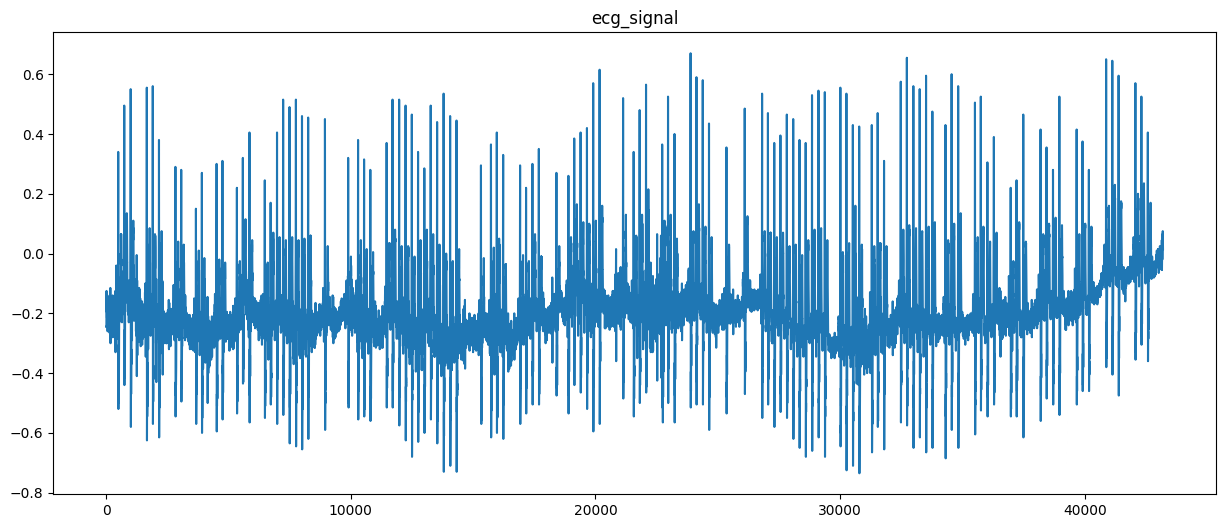

In [67]:
# record_name = '100'  # nornaml
# record_name = '203' #Atrial Fibrillationia
record_name = '232'  # Atrial Fibrillation
# record_name = '207'

try:
    record = wfdb.rdrecord(record_name)
    ecg_signal = record.p_signal[:, 0]
    fs = record.fs  # Sampling frequency (Hz)
    
    samp_sec = 120  # Number of seconds to plot
    # num_samples = int(120 * fs)  # Number of samples in 120 seconds
    num_samples = int(samp_sec * fs)
    ecg_signal = ecg_signal[:num_samples]
    print(f"Loaded record '{record_name}' with sampling rate {fs} Hz")
except FileNotFoundError:
    print(f"Error: Record '{record_name}' not found. Check PhysioNet access.")

plt.figure(figsize=(15, 6))    
plt.plot(ecg_signal)
plt.title("ecg_signal")
plt.show()
    

Amplitude Normalization

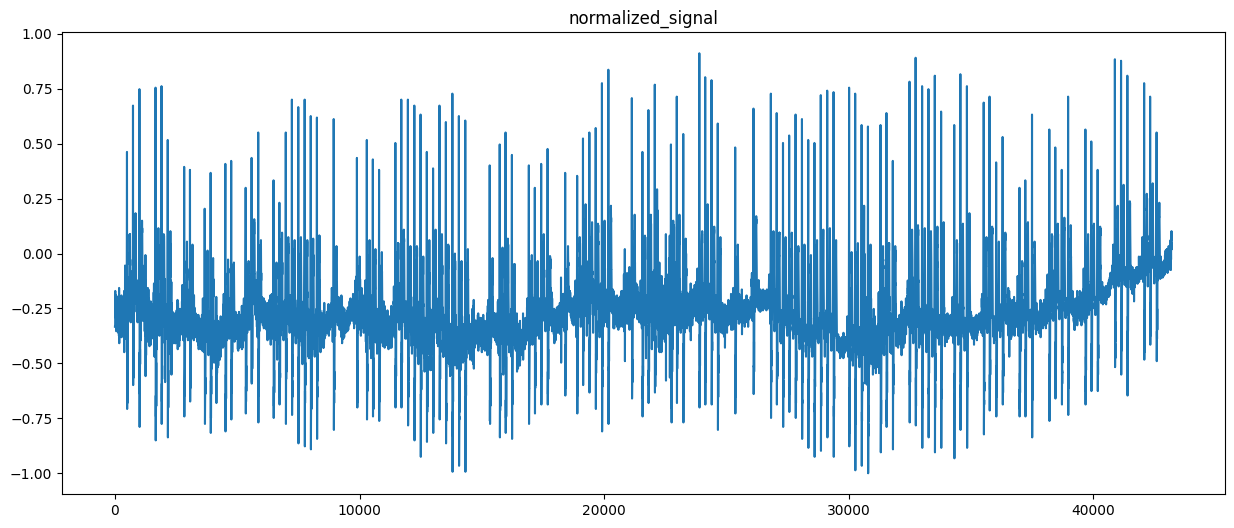

In [68]:
def amplitude_normalization(signal):
    return signal / np.max(np.abs(signal))

normalized_signal = amplitude_normalization(ecg_signal)
plt.figure(figsize=(15, 6))
plt.plot(normalized_signal)
plt.title("normalized_signal")
plt.show()

Bandpass Filtering (0.5–40 Hz)

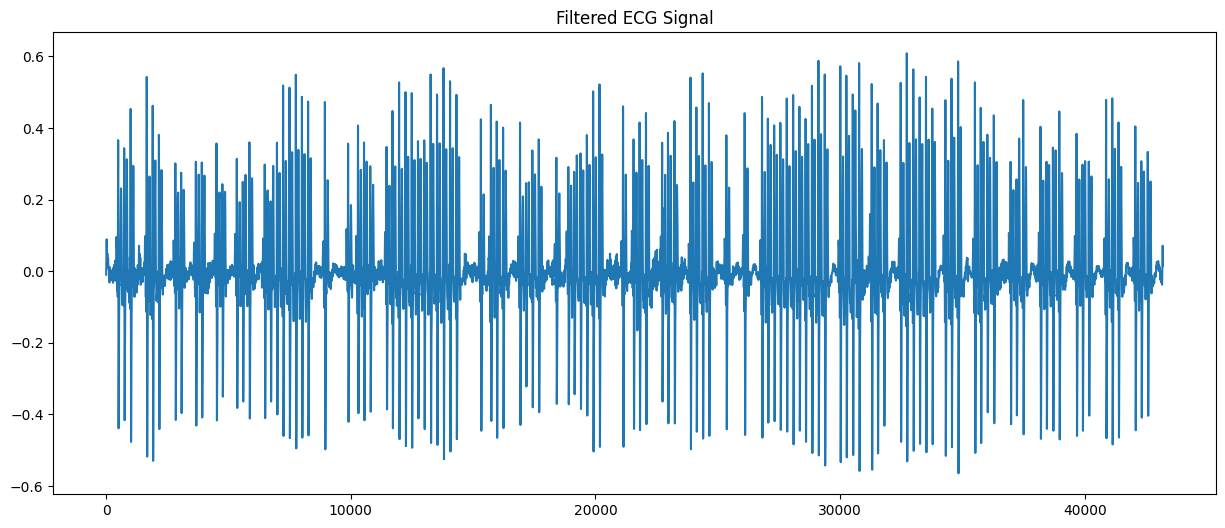

In [69]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# filtered_signal = butter_bandpass_filter(normalized_signal, 0.5, 40, fs)
filtered_signal = butter_bandpass_filter(normalized_signal, 1, 15, fs)
plt.figure(figsize=(15, 6))
plt.plot(filtered_signal)
plt.title("Filtered ECG Signal")
plt.show()

QRS Complex Detection (Pan-Tompkins)

Detected 289 QRS peaks (Pan-Tompkins)


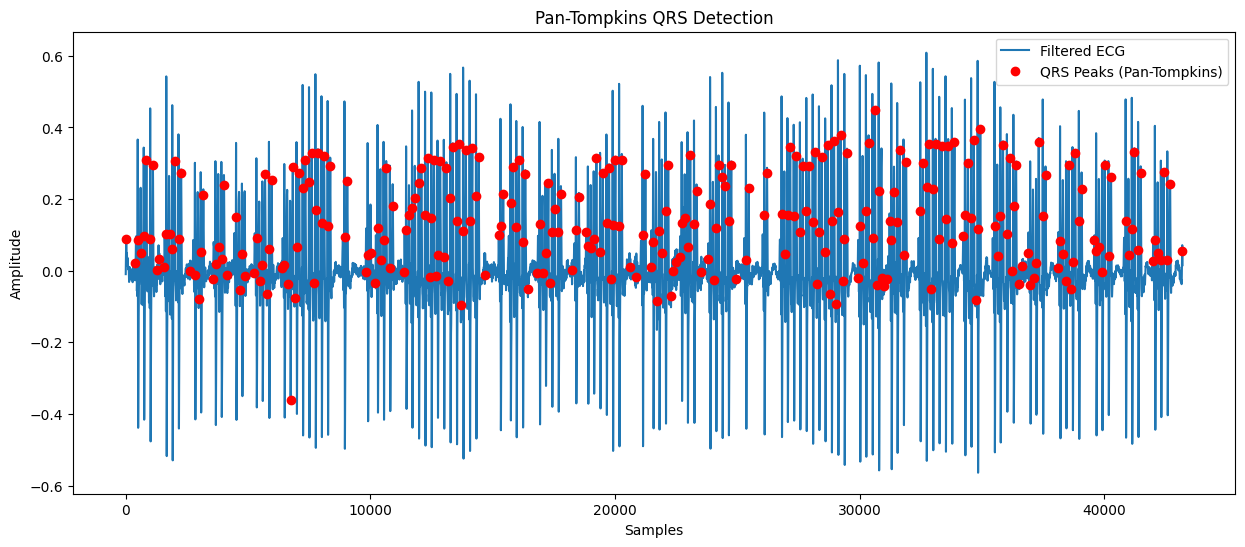

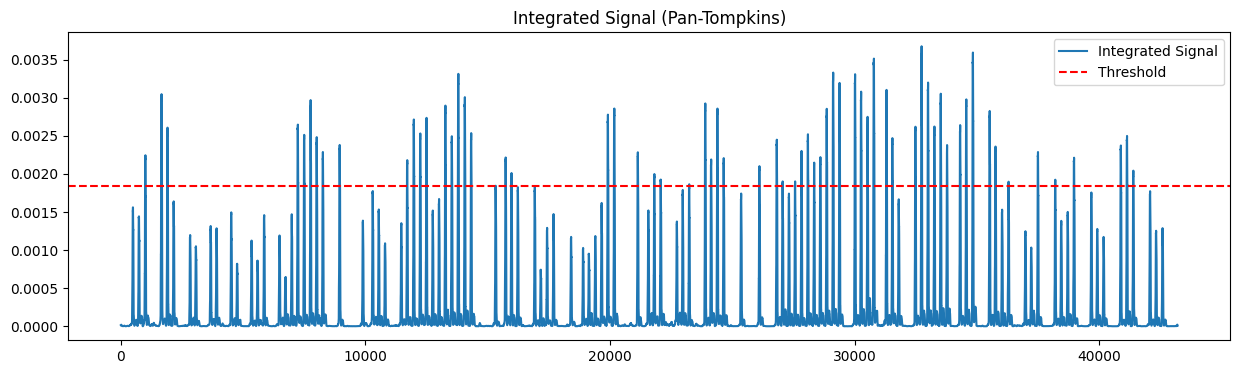

In [70]:
def pan_tompkins_qrs_detection(signal, fs, threshold_ratio=0.5):
    # 1. Differentiation
    diff_signal = np.diff(signal, prepend=signal[0])
    # 2. Squaring
    squared_signal = diff_signal ** 2
    # 3. Moving window integration
    window_size = int(0.11 * fs)
    integrated_signal = np.convolve(squared_signal, np.ones(window_size)/window_size, mode='same')
    # 4. Thresholding
    # threshold = threshold_ratio * np.max(integrated_signal)
    threshold = threshold_ratio * np.median(integrated_signal)
    qrs_peaks, _ = find_peaks(integrated_signal, height=threshold, distance=int(0.2*fs))
    return qrs_peaks, integrated_signal

# Use the function and plot results
qrs_peaks, integrated_signal = pan_tompkins_qrs_detection(filtered_signal, fs)

print(f"Detected {len(qrs_peaks)} QRS peaks (Pan-Tompkins)")

plt.figure(figsize=(15, 6))
plt.plot(filtered_signal, label='Filtered ECG')
plt.plot(qrs_peaks, filtered_signal[qrs_peaks], 'ro', label='QRS Peaks (Pan-Tompkins)')
plt.title("Pan-Tompkins QRS Detection")
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Optional: Plot the integrated signal and threshold
plt.figure(figsize=(15, 4))
plt.plot(integrated_signal, label='Integrated Signal')
plt.axhline(y=0.5 * np.max(integrated_signal), color='r', linestyle='--', label='Threshold')
plt.title("Integrated Signal (Pan-Tompkins)")
plt.legend()
plt.show()

 Feature Extraction

Detected 289 R-peaks (Pan-Tompkins)
Detected 289 R-peaks


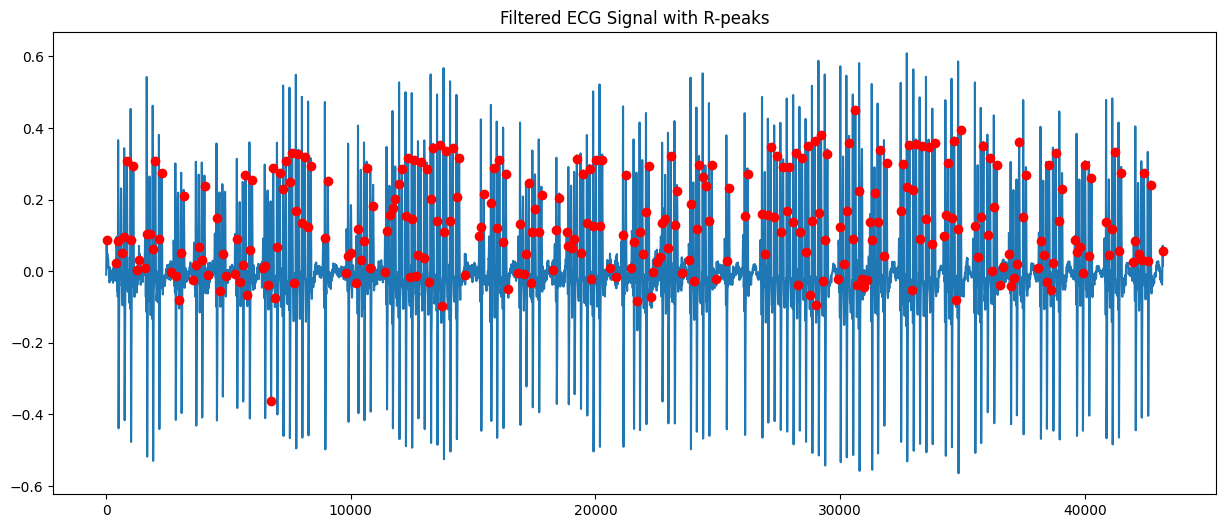

In [71]:
def detect_r_peaks(signal, fs):
    peaks, _ = find_peaks(signal, height=np.mean(signal), distance=fs*0.6)
    return peaks

# r_peaks = detect_r_peaks(filtered_signal, fs)
r_peaks = qrs_peaks  # Rename for clarity
print(f"Detected {len(r_peaks)} R-peaks (Pan-Tompkins)")
print(f"Detected {len(r_peaks)} R-peaks")
plt.figure(figsize=(15, 6))
plt.plot(filtered_signal)
plt.plot(r_peaks, filtered_signal[r_peaks], 'ro')
plt.title("Filtered ECG Signal with R-peaks")
plt.show()


Detect Q, S, P, T Peaks

Detected 289 Q-peaks at locations: [    2   382   478   628   724   828   988  1090  1253  1330  1551  1647
  1792  1891  1991  2144  2248  2625  2817  2974  3053  3158  3568  3655
  3802  3897  4002  4151  4497  4658  4738  4882  5249  5328  5482  5572
  5676  5769  5843  5947  6374  6470  6623  6740  6811  6896  6969  7070
  7219  7322  7479  7584  7667  7741  7841  7990  8090  8242  8345  8929
  9038  9786  9878 10026 10200 10282 10428 10528 10633 10784 10901 11361
 11449 11586 11691 11825 11960 12065 12224 12327 12406 12479 12582 12663
 12735 12837 12991 13093 13174 13251 13352 13513 13615 13699 13780 13883
 14045 14147 14305 14409 14669 15233 15305 15412 15714 15818 15953 16055
 16213 16316 16439 16812 16905 17058 17149 17256 17339 17408 17540 17671
 17777 18243 18389 18507 18807 18879 19022 19117 19222 19379 19484 19637
 19739 19815 19893 19999 20155 20261 20583 20828 21116 21221 21450 21547
 21702 21792 21932 22053 22155 22282 22338 22499 22634 22712 22854 22953
 23055 23217 233

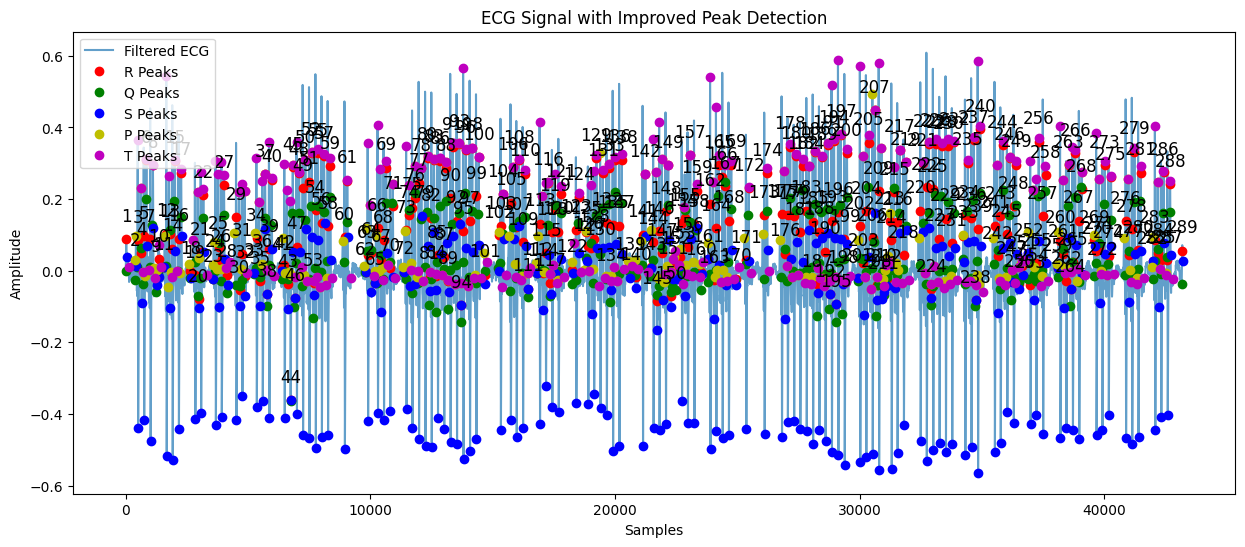

In [72]:
def detect_qs_peaks(signal, r_peaks, fs):
    q_peaks, s_peaks = [], []
    search_window = int(0.05 * fs)  # 50 ms before/after R-peak
    
    for r in r_peaks:
        # Q-peak: Search 50 ms before R-peak
        q_start = max(0, r - search_window)
        q_window = signal[q_start:r]
        if len(q_window) > 0:
            q_peak = np.argmin(q_window) + q_start
            q_peaks.append(q_peak)
        else:
            q_peaks.append(np.nan)
        
        # S-peak: Search 50 ms after R-peak
        s_end = min(len(signal), r + search_window)
        s_window = signal[r:s_end]
        if len(s_window) > 0:
            s_peak = np.argmin(s_window) + r
            s_peaks.append(s_peak)
        else:
            s_peaks.append(np.nan)
    
    return np.array(q_peaks), np.array(s_peaks)

def detect_pt_peaks(signal, r_peaks, fs):
    p_peaks, t_peaks = [], []
    r_peaks = r_peaks[~np.isnan(r_peaks)].astype(int)
    
    for i, r in enumerate(r_peaks):
        # P-wave detection (positive deflection only)
        p_start = max(0, r - int(0.3 * fs))  # 300ms before R-peak
        p_window = signal[p_start:r]
        # p_peak, _ = find_peaks(p_window, prominence=0.15 * np.max(signal))  # Increased prominence
        # Lower prominence threshold for P-waves (from 0.15 to 0.05)
        p_peak, _ = find_peaks(p_window, prominence=0.05 * np.max(signal))  # Adjusted
        
        if len(p_peak) > 0:
            p_peaks.append(p_peak[0] + p_start)
        else:
            p_peaks.append(np.nan)
        
        # T-wave: Search after R-peak
        # t_start = r + int(0.2 * fs) 
        t_start = r + int(0.2 * fs)  
        # t_end = min(len(signal), r + int(0.4 * fs))
        t_end = min(len(signal), r + int(0.5 * fs))
        t_window = signal[t_start:t_end]
        t_peak, _ = find_peaks(t_window, prominence=0.01 * np.max(signal))
        if len(t_peak) > 0:
            t_peaks.append(t_peak[0] + t_start)
        else:
            t_peaks.append(np.nan)
    
    return np.array(p_peaks), np.array(t_peaks)



q_peaks, s_peaks = detect_qs_peaks(filtered_signal, r_peaks,fs)
p_peaks, t_peaks = detect_pt_peaks(filtered_signal, r_peaks, fs)

valid_p_peaks = p_peaks[~np.isnan(p_peaks)].astype(int)
valid_r_peaks = r_peaks[~np.isnan(r_peaks)].astype(int)

# Print the detected peak counts and locations
print(f"Detected {len(q_peaks)} Q-peaks at locations: {q_peaks}")
print(f"Detected {len(s_peaks)} S-peaks at locations: {s_peaks}")
print(f"Detected {len(valid_p_peaks)} P-peaks at locations: {valid_p_peaks}")
print(f"Detected {len(t_peaks)} T-peaks at locations: {t_peaks}")

plt.figure(figsize=(15, 6))
plt.plot(filtered_signal, label='Filtered ECG', alpha=0.7)

# annotate r-peaks with numbers
for i, r in enumerate(valid_r_peaks):
    plt.text(r, filtered_signal[r] + 0.05, str(i+1), color='black', fontsize=12, ha='center')  # Annotate with peak number

plt.plot(r_peaks, filtered_signal[r_peaks], 'ro', label='R Peaks')
plt.plot(q_peaks[~np.isnan(q_peaks)].astype(int), filtered_signal[q_peaks[~np.isnan(q_peaks)].astype(int)], 'go', label='Q Peaks')
plt.plot(s_peaks[~np.isnan(s_peaks)].astype(int), filtered_signal[s_peaks[~np.isnan(s_peaks)].astype(int)], 'bo', label='S Peaks')
plt.plot(p_peaks[~np.isnan(p_peaks)].astype(int), filtered_signal[p_peaks[~np.isnan(p_peaks)].astype(int)], 'yo', label='P Peaks')
plt.plot(t_peaks[~np.isnan(t_peaks)].astype(int), filtered_signal[t_peaks[~np.isnan(t_peaks)].astype(int)], 'mo', label='T Peaks')

plt.title('ECG Signal with Improved Peak Detection')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Calculate Dynamic Features

In [73]:
rr_intervals = np.diff(r_peaks) / fs  # In seconds
heart_rate = 60 / np.mean(rr_intervals)
hrv = (np.max(rr_intervals) - np.min(rr_intervals)) * 100
print(f"Heart rate: {heart_rate:.2f} bpm")
print(f"HRV: {hrv:.2f} ms")

Heart rate: 144.13 bpm
HRV: 187.78 ms


R/P Ratio

In [74]:
# Ensure both arrays have the same length
min_length = min(len(valid_r_peaks), len(valid_p_peaks))
valid_r_peaks = valid_r_peaks[:min_length]
valid_p_peaks = valid_p_peaks[:min_length]

# Extract amplitudes
r_amplitudes = filtered_signal[valid_r_peaks]
p_amplitudes = filtered_signal[valid_p_peaks]

# Avoid division by zero
safe_p_amplitudes = np.where(p_amplitudes == 0, np.nan, p_amplitudes)
r_to_p_ratio = np.nanmean(r_amplitudes / safe_p_amplitudes)  # Ignore NaN values

print(f"R-to-P amplitude ratio: {r_to_p_ratio:.2f}")

print(f"Mean RR Interval: {np.mean(rr_intervals):.2f}s, HR: {heart_rate:.2f} bpm")
# print(f"RR Standard Deviation: {rr_std:.2f}s, P-Peak Count: {len(valid_p_peaks)}")


R-to-P amplitude ratio: -10.53
Mean RR Interval: 0.42s, HR: 144.13 bpm


Rule-Based Classification

In [75]:
classification = []

# Calculate QRS duration (ensure valid Q/S peaks)
valid_q = q_peaks[~np.isnan(q_peaks)].astype(int)
valid_s = s_peaks[~np.isnan(s_peaks)].astype(int)
min_length = min(len(valid_q), len(valid_s))
qrs_durations = (valid_s[:min_length] - valid_q[:min_length]) / fs * 1000  # milliseconds
wide_qrs = np.mean(qrs_durations) > 120  # VTach threshold

# Check for P-wave absence
p_peak_ratio = len(valid_p_peaks) / len(r_peaks) if len(r_peaks) > 0 else 0
p_absent = p_peak_ratio < 0.2  # <20% P-waves detected

# VTach classification (priority over AFib)
# Add heart rate check and adjust QRS threshold
if (heart_rate > 100) and wide_qrs and p_absent:
    classification.append("Ventricular Tachycardia (Suspected)")

# VTach classification (priority over AFib)
if wide_qrs and p_absent:
    classification.append("Ventricular Tachycardia (Suspected)")


elif heart_rate < 50:
    classification.append("Bradycardia")
elif heart_rate > 100:
    classification.append("Tachycardia")

# Atrial Fibrillation Check
rr_std = np.std(rr_intervals)
# afib_condition = (rr_std > 0.2) and (p_peak_ratio < 0.3 or r_to_p_ratio < 0.5)
# AFib requires irregular rhythm but excludes VTach cases
afib_condition = (rr_std > 0.2) and (p_peak_ratio < 0.3) and (heart_rate < 100)  # Add HR check

if afib_condition and not wide_qrs:
    classification.append("Atrial Fibrillation (Suspected)")

# Default to Normal
if not classification:
    classification.append("Normal - Healthy")
    
print(f"Mean RR Interval: {np.mean(rr_intervals):.2f}s, HR: {heart_rate:.2f} bpm")
print(f"RR Standard Deviation: {rr_std:.2f}s, P-Peak Count: {len(valid_p_peaks)}")
# Print results
print("Classification Results:", ", ".join(classification))

Mean RR Interval: 0.42s, HR: 144.13 bpm
RR Standard Deviation: 0.31s, P-Peak Count: 203
Classification Results: Tachycardia


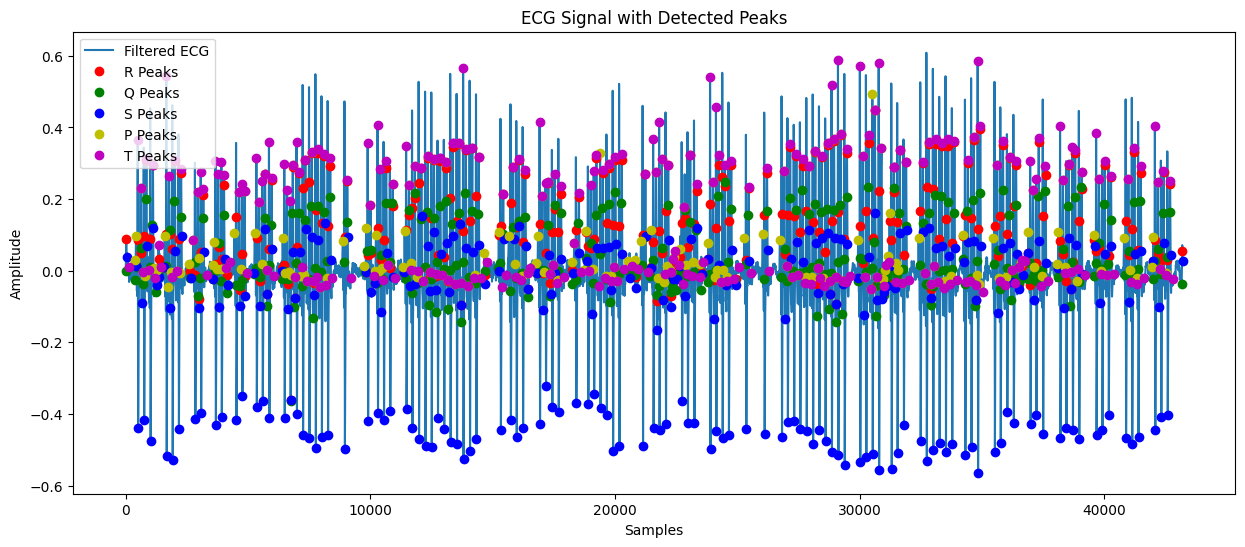

In [76]:
plt.figure(figsize=(15, 6))
plt.plot(filtered_signal, label='Filtered ECG')
plt.plot(r_peaks, filtered_signal[r_peaks], 'ro', label='R Peaks')
plt.plot(q_peaks[~np.isnan(q_peaks)].astype(int), filtered_signal[q_peaks[~np.isnan(q_peaks)].astype(int)], 'go', label='Q Peaks')
plt.plot(s_peaks[~np.isnan(s_peaks)].astype(int), filtered_signal[s_peaks[~np.isnan(s_peaks)].astype(int)], 'bo', label='S Peaks')
plt.plot(p_peaks[~np.isnan(p_peaks)].astype(int), filtered_signal[p_peaks[~np.isnan(p_peaks)].astype(int)], 'yo', label='P Peaks')
plt.plot(t_peaks[~np.isnan(t_peaks)].astype(int), filtered_signal[t_peaks[~np.isnan(t_peaks)].astype(int)], 'mo', label='T Peaks')
plt.title('ECG Signal with Detected Peaks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

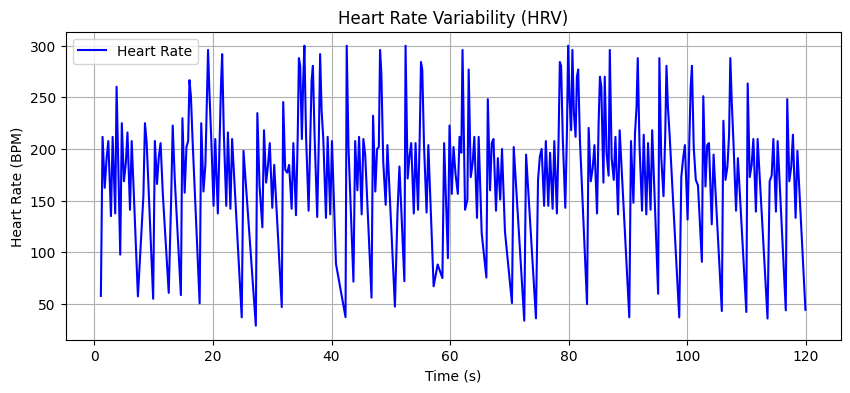

In [77]:
plt.figure(figsize=(10, 4))
plt.plot(r_peaks[1:]/fs, 60/rr_intervals, 'b-')
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (BPM)')
plt.legend(['Heart Rate'])
plt.title('Heart Rate Variability (HRV)')
plt.grid(True)
plt.show()

In [78]:
# import wfdb

# # Example: Download record 201 (contains atrial fibrillation)
# wfdb.dl_database('mitdb', dl_dir='.')
# record = wfdb.rdrecord('201')